In [214]:
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print "Import successful"

Import successful


In [215]:
try:
    data = pd.read_csv("train.csv")
    
    print "Quora duplicate questions training dataset has {} samples with {} features each.".format(*data.shape)
    
except:
    print "Dataset(s) could not be loaded. Please check filename is correct and dataset exists"

Quora duplicate questions training dataset has 404290 samples with 6 features each.


In [216]:
print "Display sample of training data:"
display(data.head(10))

Display sample of training data:


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [217]:
print "Display statistics about training data:"
display(data.describe())

Display statistics about training data:


,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [218]:
#question ids not useful information
data.drop(['id', 'qid1', 'qid2'], axis = 1, inplace = True)

#data.dropna(how = "any", axis = 0, inplace = True)
nan_penalty = 100
print "Modified Quora duplicate questions training dataset has {} samples with {} features each.".format(*data.shape)

#split into features and results
results = data['is_duplicate']
features_raw = data.drop('is_duplicate', axis = 1)

#check training features and results are as expected
display(results.head())
display(features_raw.head())

Modified Quora duplicate questions training dataset has 404290 samples with 3 features each.


0    0
1    0
2    0
3    0
4    0
Name: is_duplicate, dtype: int64

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [219]:
from sklearn.feature_extraction import stop_words

def remove_stop_words(x):
    """Preprocess text to remove 'stopwords' from it (common words with little useful information)"""
    try:
        original_words = x.split()
        output = " "

        for word in original_words:
            if not word in stop_words.ENGLISH_STOP_WORDS:
                output += word + " "

        return output[:-1]
    except: #for the case of NaN entries
        return None

In [220]:
#Test that the remove_stop_words function works as expected
print remove_stop_words("Say hello to the cat")
print remove_stop_words("I am six years old")

 Say hello cat
 I years old


In [221]:
def to_lower_case(x):
    """Convert all text to lowercase"""
    try:
        return x.lower()
    except:
        return None

In [222]:
### Data pre-processing ###

display(features_raw.head())

#Make all text lower case
features_raw["question1"] = features_raw["question1"].apply(to_lower_case)
features_raw["question2"] = features_raw["question2"].apply(to_lower_case)

#Remove stopwords
features_raw["question1"] = features_raw["question1"].apply(remove_stop_words)
features_raw["question2"] = features_raw["question2"].apply(remove_stop_words)

display(features_raw.head())

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


,question1,question2
0,step step guide invest share market india?,step step guide invest share market?
1,story kohinoor (koh-i-noor) diamond?,happen indian government stole kohinoor (koh-...
2,increase speed internet connection using vpn?,internet speed increased hacking dns?
3,mentally lonely? solve it?,"remainder [math]23^{24}[/math] divided 24,23?"
4,"dissolve water quikly sugar, salt, methane ca...",fish survive salt water?


In [223]:
def diff_num_chars(x):
    """Create new feature - return the difference in length of both questions, in terms of total number of chars"""
    try:
        len1 = len(x["question1"])
        len2 = len(x["question2"])
        return len1 - len2
    except:
        #print x["question1"]    #print unexpected output for debug
        #print x["question2"]
        return nan_penalty

In [224]:
def diff_num_words(x):
    """Create new feature - return the difference in length of both questions, in terms of total number of words"""
    try:
        len1 = len(x["question1"].split())
        len2 = len(x["question2"].split())
        return len1 - len2
    except:
        #print x["question1"]   #print unexpected output for debug
        #print x["question2"]
        return nan_penalty

In [225]:
def num_common_words(x):
    """Create new feature - return the number of common words between both questions"""
    try:
        words1 = x["question1"].split()
        words2 = x["question2"].split()
        
        common_words = 0
        
        for word in words1:
            word_l = word
            if word in words2:
                common_words += 1
                
        return common_words
        
    except:
        #print x["question1"]  #print unexpected output for debug
        #print x["question2"]
        return 0

In [226]:
def ratio_common_words(x):
    """Create new feature - return ratio of common words between both questions"""
    try:
        return 1.0 * num_common_words(x) / (len(x["question1"].split()) + len(x["question2"].split()))
    except:
        return 0

In [227]:
features = pd.DataFrame()
features["diff_num_chars"] = features_raw.apply(diff_num_chars, axis=1)
features["diff_num_words"] = features_raw.apply(diff_num_words, axis=1)
features["num_common_words"] = features_raw.apply(num_common_words, axis=1)
features["ratio_common_words"] = features_raw.apply(ratio_common_words, axis=1)
display(features.head())

,diff_num_chars,diff_num_words,num_common_words,ratio_common_words
0,6,1,5,0.384615
1,-30,-4,2,0.166667
2,8,1,2,0.181818
3,-19,0,0,0.000000
4,35,5,0,0.000000


In [228]:
from sklearn.cross_validation import train_test_split

#Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, results, test_size = 0.2, random_state = 17)

print "Training and testing split was successful."

Training and testing split was successful.


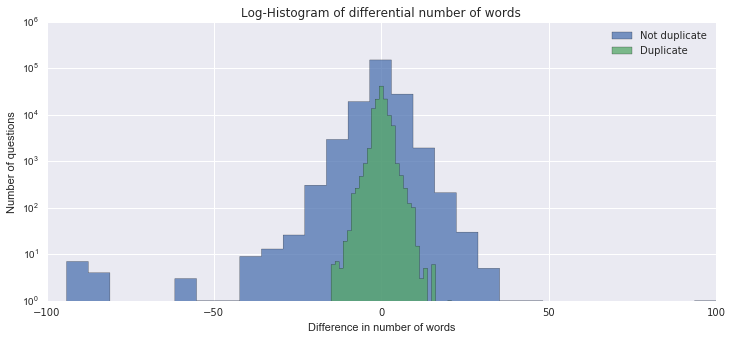

In [229]:
### Visualisation - plot histogram showing how distrubtion of differential number of words between both questions
### varies between duplicate and non-duplicate questions ###

# Histogram plotting techniques inspired by:
# https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb

plt.figure(figsize=(12, 5))
plt.hist(X_train["diff_num_words"][y_train == 0], bins=30, histtype="stepfilled", alpha = 0.75,label="Not duplicate")
plt.hist(X_train["diff_num_words"][y_train == 1], bins=30, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of differential number of words')
plt.xlabel('Difference in number of words')
plt.ylabel('Number of questions')
plt.legend()
print

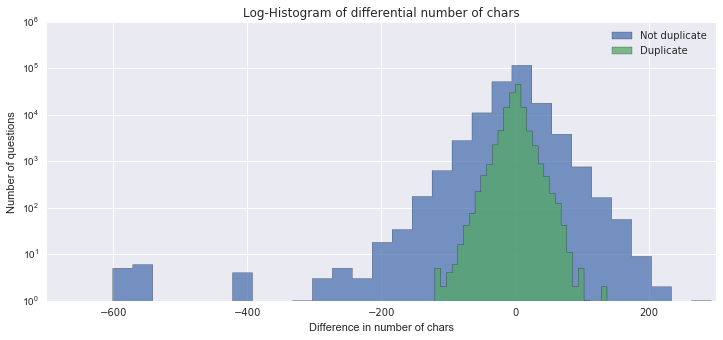

In [230]:
### Visualisation - plot histogram showing how distrubtion of differential number of chars between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["diff_num_chars"][y_train == 0], bins=30, histtype="stepfilled", alpha = 0.75,label="Not duplicate")
plt.hist(X_train["diff_num_chars"][y_train == 1], bins=30, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of differential number of chars')
plt.xlabel('Difference in number of chars')
plt.ylabel('Number of questions')
plt.legend()
print

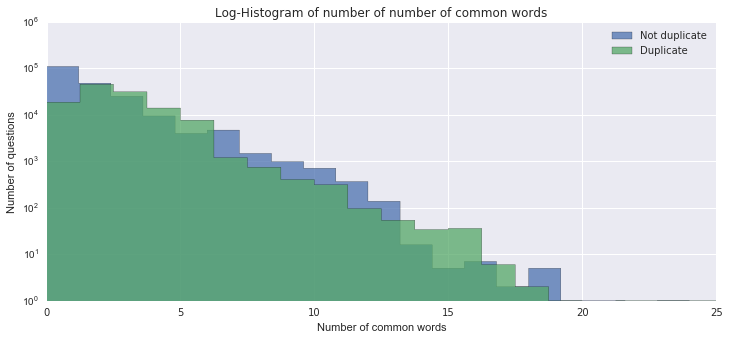

In [231]:
### Visualisation - plot histogram showing how distrubtion of number of common words between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["num_common_words"][y_train == 0], bins=20, histtype="stepfilled", alpha = 0.75, label="Not duplicate")
plt.hist(X_train["num_common_words"][y_train == 1], bins=20, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of number of number of common words')
plt.xlabel('Number of common words')
plt.ylabel('Number of questions')
plt.legend()
print

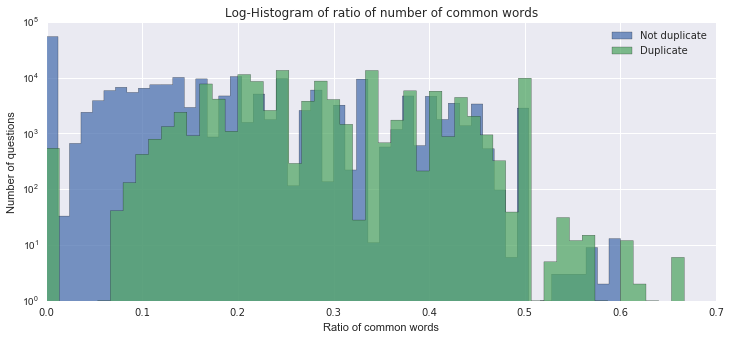

In [232]:
### Visualisation - plot histogram showing how distrubtion of ratio of common words between both questions
### varies between duplicate and non-duplicate questions ###

plt.figure(figsize=(12, 5))
plt.hist(X_train["ratio_common_words"][y_train == 0], bins=50, histtype="stepfilled", alpha = 0.75, label="Not duplicate")
plt.hist(X_train["ratio_common_words"][y_train == 1], bins=50, histtype="stepfilled", alpha = 0.75, label="Duplicate")
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of ratio of number of common words')
plt.xlabel('Ratio of common words')
plt.ylabel('Number of questions')
plt.legend()
print

In [233]:
from sklearn.metrics import log_loss

def performance_metric(y_true, y_predict):
    """ Calculate and return the performance score between true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'  
    score = log_loss(y_true, y_predict)
    
    # Return the score
    return score

In [234]:
from sklearn.metrics import make_scorer
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):
    """ Perform grid search over the 'max_depth' parameter for a decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # Create regressor object
    #regressor = DecisionTreeRegressor()
    regressor = RandomForestRegressor(n_estimators = 20)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':(10, None)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [235]:
# Fit the training data to the model using grid search

X_train.drop(["diff_num_chars"], axis = 1, inplace = True)
X_test.drop(["diff_num_chars"], axis = 1, inplace = True)
X_train.drop(["num_common_words"], axis = 1, inplace = True)
X_test.drop(["num_common_words"], axis = 1, inplace = True)

reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

/Users/Adam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Adam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Adam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Parameter 'max_depth' is None for the optimal model.


/Users/Adam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [236]:
#test_questions = [["Hello", "Hello world"], ["Why is the sky blue?", "Why is the sky not blue?"], ["What is pi?", "What is pi?"]]
print features_raw["question1"][3411], features_raw["question2"][3411]
display(X_test.head())
reg.predict(X_test.head())

print performance_metric(y_test, reg.predict(X_test))

 money average earning shopaholics spend clothes accessories?  year, money does movie buff spend average watch movies cinema hall? does avoid bad films?


,diff_num_words,ratio_common_words
225143,-2,0.125000
162274,0,0.125000
217127,-4,0.000000
394527,-1,0.285714
55570,0,0.250000
67848,0,0.437500
325138,0,0.250000
146588,0,0.000000
236711,0,0.500000
211378,1,0.444444


0.484609660737


In [237]:
#Load the competition testing data set

try:
    test_data = pd.read_csv("test.csv")
    
    print "Quora duplicate questions competion test dataset has {} samples with {} features each.".format(*test_data.shape)
    
except:
    print "Dataset(s) could not be loaded. Please check filename is correct and dataset exists"

Quora duplicate questions competion test dataset has 2345796 samples with 3 features each.


In [238]:
#Pre-process competition test data in same was as training data
display(test_data.head())

#Make all text lower case
test_data["question1"] = test_data["question1"].apply(to_lower_case)
test_data["question2"] = test_data["question2"].apply(to_lower_case)

#Remove stop words
test_data["question1"] = test_data["question1"].apply(remove_stop_words)
test_data["question2"] = test_data["question2"].apply(remove_stop_words)

test_data_features = pd.DataFrame()
#test_data_features["diff_num_chars"] = test_data.apply(diff_num_chars, axis=1)
test_data_features["diff_num_words"] = test_data.apply(diff_num_words, axis=1)
#test_data_features["num_common_words"] = test_data.apply(num_common_words, axis=1)
test_data_features["ratio_common_words"] = test_data.apply(ratio_common_words, axis=1)
display(test_data_features.head())

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


,diff_num_words,ratio_common_words
0,-4,0.111111
1,0,0.200000
2,3,0.222222
3,0,0.000000
4,1,0.400000


In [239]:
test_predictions = reg.predict(test_data_features)
#print "Test_data_features shape: ", test_data_features.shape
#print "Test_predictions shape: ", test_predictions.shape
final_output = pd.concat([test_data["test_id"], pd.Series(test_predictions, name = "is_duplicate")], axis=1)

#print "Final output has {} samples with {} features each.".format(*final_output.shape)
#print final_output["test_id"][2345793],final_output["is_duplicate"][2345793]

display(final_output.head())

,test_id,is_duplicate
0,0,0.021651
1,1,0.536919
2,2,0.558280
3,3,0.025199
4,4,0.588574


In [240]:
final_output.to_csv("final_output.csv", index = False)
print "Final predictions written to final_output.csv successfully"

Final predictions written to final_output.csv successfully
